# Predict size of cluster from text content

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.utils import shuffle

%matplotlib inline

import lib.helper as helper

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [99]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score              # Evaluate a model
from sklearn.metrics import f1_score                    # Evaluate a model
from sklearn.metrics import precision_score             # Evaluate a model
from sklearn.metrics import recall_score                # Evaluate a model

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Tools for evaluating the model by running it repeatedly with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

## 01.  Create features, labels, train-val-test split

In [4]:
# Load the corpus
df = pd.read_csv("working/RSS_clustered_louvain.csv")

In [5]:
# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(helper.preprocess_description)
df['phrased_tokens'] = helper.get_phrased_nouns(df['clean_text'])

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

df = df[df['cluster'] != -1]
#df['cluster_size'] = np.where(df['cluster']==-1, 0.0, df['cluster_size'])

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']]

,cluster_size,tokens,phrased_tokens
4,863,"[syria, war, turkey, warn, europ, new, migrant...","[syria_turkey, europ, presid_erdogan, syria]"
29,82,"[trump, news, presid, lash, amid, widespread, ...","[presid, afghan, donald_trump, oval_offic, hur..."
33,59,"[berni, sander, take, victori, lap, iowa, stat...","[berni_sander, iowa, state, fair, soapbox, iow..."
34,6,"[itali, success, eject, far, right, leader, sa...","[itali_salvini, matteo_salvini, leagu, europ]"
44,82,"[trump, launch, angri, attack, grace, star, hu...","[grace, hurrican_dorian, ms, mess, american, m..."
...,...,...,...
31379,20,"[trump, coward, complicit, russia, bounti, cla...","[russia, ex, navi_seal, donald_trump]"
31383,505,"[insid, amsterdam, red, light, district, sex, ...","[amsterdam, pm, mark, rutt, amsterdam, red, li..."
31385,291,"[kim, jong, threaten, ww, south, korea, dirti,...","[kim_jong, ww, south_korea, north_korea, kim_j..."
31391,584,"[far, bank, england, predict, quick, econom, b...","[bank_england, quick, econom, uk, gdp]"


In [75]:
vectorizer = TfidfVectorizer(decode_error="ignore",
                             max_features=300)

# Create feature vectors
X = vectorizer.fit_transform(df['phrased_tokens'].apply(" ".join))

# Create Labels
y = np.asarray(df['cluster_size'].astype(float))

# Check that worked
print(X.shape, y.shape)

# Split the data, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(6131, 300) (6131,)


In [102]:
# Define the measurements we want to make
scoring = {'MSE': make_scorer(mean_squared_error),
           'MAE': make_scorer(mean_absolute_error)}

parameters = {'alpha':[0.1, 0.5, 1.0, 2.0, 3.0],
              'l1_ratio': [0.0, 0.5, 1.0]}

model = ElasticNet()

# Perform cross-validated grid-search
clf = GridSearchCV(estimator=model,
                   cv=5,
                   param_grid=parameters,
                   return_train_score=True,
                   n_jobs=10,
                   refit=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

GridSearchCV(estimator=ElasticNet(), n_jobs=10,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 3.0],
                         'l1_ratio': [0.0, 0.5, 1.0]},
             return_train_score=True)

In [107]:
# Look at the performance of each hyperparameter combination
pd.DataFrame(clf.cv_results_)\
  [['params', 'mean_train_score', 'std_train_score']]\
  .sort_values("mean_train_score", ascending=False)

,params,mean_train_score,std_train_score
2,"{'alpha': 0.1, 'l1_ratio': 1.0}",0.488101,0.007187
5,"{'alpha': 0.5, 'l1_ratio': 1.0}",0.354540,0.005607
8,"{'alpha': 1.0, 'l1_ratio': 1.0}",0.237029,0.006339
11,"{'alpha': 2.0, 'l1_ratio': 1.0}",0.125280,0.005183
1,"{'alpha': 0.1, 'l1_ratio': 0.5}",0.118685,0.003412
14,"{'alpha': 3.0, 'l1_ratio': 1.0}",0.088421,0.008028
0,"{'alpha': 0.1, 'l1_ratio': 0.0}",0.072210,0.002318
4,"{'alpha': 0.5, 'l1_ratio': 0.5}",0.028205,0.001132
3,"{'alpha': 0.5, 'l1_ratio': 0.0}",0.017096,0.000633
7,"{'alpha': 1.0, 'l1_ratio': 0.5}",0.012702,0.000594


In [114]:
def help_get_coefs(fitted_model, feature_names):
    """
    Gets ordered table of coefficient names and magnitudes
    """
    df = pd.DataFrame({"name": feature_names,
                       "coefficient": fitted_model.coef_})
    
    # MAGNITUDES rather than VALUE determine importance
    df['abs_value'] = df['coefficient'].apply(abs)
    
    return df.sort_values("abs_value", ascending=False)

# In this call, retrieving final (selected and retrained)
# estimator from the grid search
coef_table = help_get_coefs(clf.best_estimator_, list(vectorizer.get_feature_names()))

coef_table

,name,coefficient,abs_value
291,world_econom,716.653464,716.653464
256,taliban,542.699665,542.699665
125,iran_iraq,507.093647,507.093647
196,nobel_peac,501.641194,501.641194
222,qasem_soleimani,496.485372,496.485372
...,...,...,...
223,queen,0.000000,0.000000
221,pyongyang,0.000000,0.000000
219,prize,0.000000,0.000000
96,friday,0.000000,0.000000


In [115]:
# How many features ultimately selected?
# (they're regularised to NEAR zero, so need a tolerance)
coef_table[coef_table['abs_value'] >= 0.0001]

,name,coefficient,abs_value
291,world_econom,716.653464,716.653464
256,taliban,542.699665,542.699665
125,iran_iraq,507.093647,507.093647
196,nobel_peac,501.641194,501.641194
222,qasem_soleimani,496.485372,496.485372
...,...,...,...
216,princ_harri,-5.598361,5.598361
284,war,3.163650,3.163650
28,bbc,-2.627719,2.627719
12,american,-0.994520,0.994520


## Diagnostic Plots
I'm, to some degree, improvising my own because no single python package quite does everything I'd expect R to do for a linear regression...

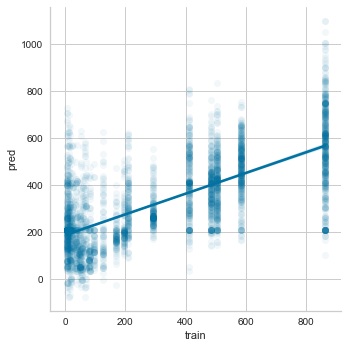

In [116]:
temp_df = pd.DataFrame({"train": y_train,
                        "pred": y_pred})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

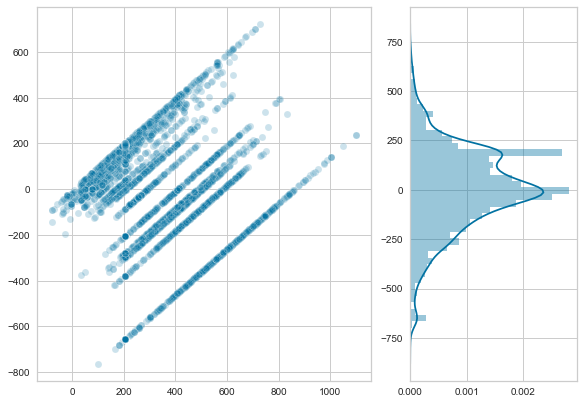

In [121]:
def help_plot_residuals(fitted_model, X, y):
    """
    Utility function:  Plot residual values for a given model
    and features + predictions
    """
    predicted = fitted_model.predict(X)
    residuals = predicted - y
    
    f = plt.figure(constrained_layout=True)
    gs = f.add_gridspec(3, 3)
    f_ax0 = f.add_subplot(gs[:, :-1])
    f_ax1 = f.add_subplot(gs[:, -1])
    
    # Residuals vs predicted
    sns.scatterplot(x=predicted, y=residuals, alpha=0.2, ax=f_ax0)
    
    # Hist of residuals
    sns.distplot(a=residuals, hist=True, vertical=True, ax=f_ax1)

    
help_plot_residuals(clf.best_estimator_, X_train, y_train)

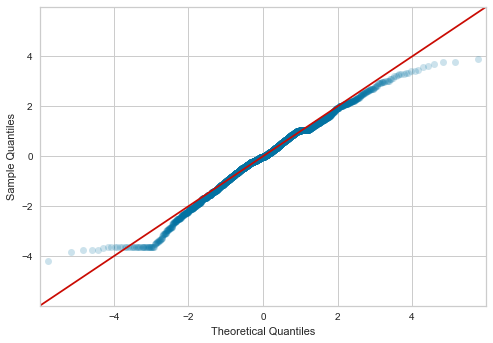

In [122]:
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.2)
plt.show()

## Examine features using simple linear regression

In [88]:
# Fit a traditional Linear Regression Model so that we can examine the p-values and r2 values
# of different features

import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

In [89]:
df_stats = pd.DataFrame(data=X_train.todense(), columns=list(vectorizer.get_feature_names()))
df_stats.head()

df_stats['StorySize'] = y_train

In [90]:
Xk = df_stats[list(vectorizer.get_feature_names())]
Ym = df_stats['StorySize']

Xm = sm.add_constant(Xk)
#fitting the the model for multiple regression 
Km = sm.OLS(Ym,Xm ).fit()
Km.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              StorySize   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     12.31
Date:                Sat, 08 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:51:56   Log-Likelihood:                -27772.
No. Observations:                4107   AIC:                         5.615e+04
Df Residuals:                    3806   BIC:                         5.805e+04
Df Model:                         300                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 192.2625     10.360     18.559      0.000     171.952     212.573
abu_bakr             -246.1184    276.704     -0.889      0.374    -788.621     296.384
afghanistan           288.8515     76.332      3.784      0.000     139.196     438.507
africa                -96.3353     81.997     -1.175      0.240    -257.098      64.427
air_forc             -303.2473     79.681     -3.806      0.000    -459.468    -147.026
airlin               -280.5560     75.780     -3.702      0.000    -429.129    -131.983
airport              -175.6552     63.458     -2.768      0.006    -300.070     -51.240
al                   -164.4500     66.281     -2.481      0.013    -294.400     -34.500
al_baghdadi           -41.5210    246.907     -0.168      0.866    -525.604     442.562
al_qaeda              252.6890    113.958      2.217      0.027      29.263     476.115
amazon               -181.6129     95.186     -1.908      0.056    -368.233       5.007
amelia_bambridg      -222.7404     78.949     -2.821      0.005    -377.526     -67.955
america                73.4350     63.611      1.154      0.248     -51.281     198.150
american              -34.5018     58.774     -0.587      0.557    -149.734      80.730
andrew                  3.4524     78.441      0.044      0.965    -150.338     157.243
april                  93.8305     60.930      1.540      0.124     -25.627     213.288
archi                  83.5525    122.789      0.680      0.496    -157.186     324.291
armi                 -182.4555    100.951     -1.807      0.071    -380.379      15.469
ashura                 62.5005     91.784      0.681      0.496    -117.450     242.451
assad                 186.1723    101.235      1.839      0.066     -12.307     384.652
august               -133.7958     83.212     -1.608      0.108    -296.940      29.349
aussi                -106.5283     94.245     -1.130      0.258    -291.304      78.247
australia            -123.1223     41.364     -2.977      0.003    -204.220     -42.025
ayia_napa            -242.1451     72.775     -3.327      0.001    -384.826     -99.464
baghdad               494.2837    111.527      4.432      0.000     275.626     712.941
baghdadi             -109.8370     84.196     -1.305      0.192    -274.911      55.237
bahama                -13.9749     94.242     -0.148      0.882    -198.745     170.795
bakr_al              -340.2253    405.935     -0.838      0.402   -1136.096     455.645
barcelona            -134.2007     90.825     -1.478      0.140    -312.271      43.869
bbc                   -39.7543     75.901     -0.524      0.600    -188.565     109.056
beach                  14.0051     82.729      0.169      0.866    -148.192     176.202
beij                   80.8730     71.509      1.131      0.258     -59.327     221.073
ber